In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import os, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from tensorflow.keras import layers, models, callbacks, optimizers, losses
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import random
import seaborn as sns
from __future__ import annotations
import argparse, json, os
from river import drift
import optuna
import calendar
from optuna.integration import TFKerasPruningCallback
print("TF:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


# Enable GPU memory growth (good practice on Kaggle)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception as e:
            print("Memory growth set error:", e)

# Mixed precision (gives speedup on modern GPUs). You can disable by setting to "float32".
USE_MIXED_PRECISION = True
if USE_MIXED_PRECISION:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision:", mixed_precision.global_policy())








path_drift = './dataset/Retrofit/_simulation.csv'
path_No_drift = './dataset/NoDrift/_simulation.csv'

TF: 2.20.0
GPU available: []
Mixed precision: <DTypePolicy "mixed_float16">


In [4]:
SEED_VALUE = 42

os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
print(f"Random seeds set to {SEED_VALUE} for reproducibility.")

Random seeds set to 42 for reproducibility.


In [5]:
def preprocess_data(
    df: pd.DataFrame,
    decimals: int = 1,
    retrofit_index: Optional[int] = None,
    prefer_global: bool = True,  # if both exist, keep radiation_global_hor
) -> pd.DataFrame:
    dfp = df.copy()

    # 1) Rename
    rename = {
        'thermalZone.TAir': 'room_temp',
        'totalHeatingPower.y': 'heating_power',
        'roomTempUpperSetpoint': 'room_temp_setpoint_upper',
        'weaBus.TDryBul': 'outdoor_temp',
        'weaBus.HDifHor': 'radiation_diffuse_hor',
        'weaBus.HDirNor': 'radiation_direct_norm',
        'weaDat.weaBus.HGloHor': 'radiation_global_hor',
        'timestamp': 'timestamp_sec',
    }
    dfp = dfp.rename(columns=rename)

    # 2) Kelvin → Celsius
    K = 273.15
    if 'room_temp' in dfp.columns:
        dfp['room_temp'] = dfp['room_temp'] - K
    if 'outdoor_temp' in dfp.columns:
        dfp['outdoor_temp'] = dfp['outdoor_temp'] - K

    # 3) Round numerics
    float_cols = dfp.select_dtypes(include=np.floating).columns
    if len(float_cols):
        dfp[float_cols] = dfp[float_cols].round(decimals)

    # 4) Guards
    need_cols = ['day_of_year', 'seconds_of_day']
    miss = [c for c in need_cols if c not in dfp.columns]
    if miss:
        raise ValueError(f"Expected columns {need_cols}; missing: {miss}")

    # 5) Year from day_of_year resets
    year_change = dfp['day_of_year'].diff() < 0
    dfp['year'] = year_change.cumsum() + 1

    # 6) Month (leap-aware per year)
    def _day_to_month_vectorized(doy: np.ndarray, is_leap: bool) -> np.ndarray:
        # cumulative month day starts (non-leap vs leap)
        cum_nl = np.array([0,31,59,90,120,151,181,212,243,273,304,334,365])
        cum_lp = np.array([0,31,60,91,121,152,182,213,244,274,305,335,366])
        edges = cum_lp if is_leap else cum_nl
        # bins are right-closed months 1..12
        return np.searchsorted(edges, np.clip(doy.astype(int) - 1, 0, None), side="right")

    dfp['month'] = 0
    for _, idx in dfp.groupby('year').groups.items():
        is_leap = int(dfp.loc[idx, 'day_of_year'].max()) == 366
        dfp.loc[idx, 'month'] = _day_to_month_vectorized(
            dfp.loc[idx, 'day_of_year'].to_numpy(), is_leap
        ).astype(int)

    # 7) Cyclic time features
    # 7a) Daily cycle (not leap-related)
    x_day = dfp['seconds_of_day'].astype(float) / 86400.0
    dfp['tod_sin'] = np.sin(2 * np.pi * x_day)
    dfp['tod_cos'] = np.cos(2 * np.pi * x_day)

    # 7b) Annual cycle (leap-aware per year)
    dfp['doy_sin'] = 0.0
    dfp['doy_cos'] = 0.0
    for _, idx in dfp.groupby('year').groups.items():
        max_doy = float(dfp.loc[idx, 'day_of_year'].max())
        denom = 366.0 if max_doy == 366.0 else 365.0
        theta = 2 * np.pi * (dfp.loc[idx, 'day_of_year'].astype(float) / denom)
        dfp.loc[idx, 'doy_sin'] = np.sin(theta)
        dfp.loc[idx, 'doy_cos'] = np.cos(theta)

    # 8) Retrofit flag (optional)
    if retrofit_index is not None:
        dfp['is_retrofit'] = 0
        dfp.loc[retrofit_index:, 'is_retrofit'] = 1

    # 9) Radiation choice
    has_diff = 'radiation_diffuse_hor' in dfp.columns
    has_glob = 'radiation_global_hor' in dfp.columns
    if has_diff and has_glob:
        dfp = dfp.drop(columns=['radiation_diffuse_hor'] if prefer_global else ['radiation_global_hor'])

    # 10) Drop unwanted + helpers (keep day_of_year for plotting/splits)
    drop_unwanted = [
        'u',
        'Day',
        'hour', 'time_of_day_slot',
        'radiation_direct_norm',
        'room_temp_setpoint_upper',
        'index',
    ]
    dfp = dfp.drop(columns=[c for c in drop_unwanted if c in dfp.columns], errors='ignore')

    # 11) Final column order
    preferred_order = [
        'room_temp',
        'heating_power',
        'outdoor_temp',
        'radiation_global_hor',   # or 'radiation_diffuse_hor' if prefer_global=False
        'tod_sin','tod_cos',
        'doy_sin','doy_cos',
        'day_of_year', 
        'seconds_of_day'
        'year',
        'month',
        'timestamp_sec'
    ]
    exist = [c for c in preferred_order if c in dfp.columns]
    others = [c for c in dfp.columns if c not in exist]
    dfp = dfp[exist + others]

    return dfp
# Load your raw data
df_drift = pd.read_csv(path_drift)
df_nodrift = pd.read_csv(path_No_drift)
# Run the complete pipeline
df_drift = preprocess_data(df_drift, decimals=1)  
df_nodrift = preprocess_data(df_nodrift, decimals=1)  

In [6]:
df_nodrift.head()

,room_temp,heating_power,outdoor_temp,radiation_global_hor,tod_sin,tod_cos,doy_sin,doy_cos,day_of_year,month,timestamp_sec,seconds_of_day,year
0,20.0,0.0,-2.3,0.0,0.000000,1.000000,0.017213,0.999852,1,1,0,0,1
1,19.5,0.0,-2.3,0.0,0.065403,0.997859,0.017213,0.999852,1,1,900,900,1
2,19.5,163.1,-2.4,0.0,0.130526,0.991445,0.017213,0.999852,1,1,1800,1800,1
3,19.5,330.5,-2.4,0.0,0.195090,0.980785,0.017213,0.999852,1,1,2700,2700,1
4,19.5,532.6,-2.5,0.0,0.258819,0.965926,0.017213,0.999852,1,1,3600,3600,1


In [7]:
df_drift.head()

,room_temp,heating_power,outdoor_temp,radiation_global_hor,tod_sin,tod_cos,doy_sin,doy_cos,day_of_year,month,timestamp_sec,seconds_of_day,year
0,20.0,0.0,-2.3,0.0,0.000000,1.000000,0.017213,0.999852,1,1,0,0,1
1,19.5,0.0,-2.3,0.0,0.065403,0.997859,0.017213,0.999852,1,1,900,900,1
2,19.5,163.1,-2.4,0.0,0.130526,0.991445,0.017213,0.999852,1,1,1800,1800,1
3,19.5,330.5,-2.4,0.0,0.195090,0.980785,0.017213,0.999852,1,1,2700,2700,1
4,19.5,532.6,-2.5,0.0,0.258819,0.965926,0.017213,0.999852,1,1,3600,3600,1


In [8]:
df_drift.corr()

,room_temp,heating_power,outdoor_temp,radiation_global_hor,tod_sin,tod_cos,doy_sin,doy_cos,day_of_year,month,timestamp_sec,seconds_of_day,year
room_temp,1.000000,-0.403885,0.781087,0.440678,-1.455586e-02,-1.665143e-01,-1.872313e-01,-7.676884e-01,9.948697e-02,1.014325e-01,0.309201,3.264633e-02,2.998957e-01
heating_power,-0.403885,1.000000,-0.481098,-0.172059,-2.783078e-02,-4.891691e-02,1.216454e-01,4.525256e-01,-1.444646e-01,-1.470795e-01,-0.418568,3.508892e-02,-4.049242e-01
outdoor_temp,0.781087,-0.481098,1.000000,0.477636,-1.500071e-01,-2.741324e-01,-2.556086e-01,-7.859067e-01,1.962338e-01,1.994447e-01,0.055231,1.167973e-01,3.359533e-02
radiation_global_hor,0.440678,-0.172059,0.477636,1.000000,2.500698e-01,-6.276732e-01,5.270692e-02,-3.512186e-01,-4.223889e-02,-4.157380e-02,0.003784,-1.165614e-01,8.565629e-03
tod_sin,-0.014556,-0.027831,-0.150007,0.250070,1.000000e+00,1.855776e-17,-1.174948e-18,-1.462507e-18,-4.529524e-18,3.571403e-18,-0.000237,-7.794607e-01,2.828726e-18
tod_cos,-0.166514,-0.048917,-0.274132,-0.627673,1.855776e-17,1.000000e+00,-6.568124e-20,1.438208e-18,2.374498e-18,4.356197e-19,-0.000008,-2.551690e-02,3.202513e-19
doy_sin,-0.187231,0.121645,-0.255609,0.052707,-1.174948e-18,-6.568124e-20,1.000000e+00,1.048481e-05,-7.803693e-01,-7.811948e-01,-0.086697,1.372321e-15,1.149126e-05
doy_cos,-0.767688,0.452526,-0.785907,-0.351219,-1.462507e-18,1.438208e-18,1.048481e-05,1.000000e+00,5.233523e-03,2.113853e-03,-0.000746,1.422371e-16,-1.335871e-03
day_of_year,0.099487,-0.144465,0.196234,-0.042239,-4.529524e-18,2.374498e-18,-7.803693e-01,5.233523e-03,1.000000e+00,9.965002e-01,0.109089,-1.662122e-15,-2.035229e-03
month,0.101433,-0.147080,0.199445,-0.041574,3.571403e-18,4.356197e-19,-7.811948e-01,2.113853e-03,9.965002e-01,1.000000e+00,0.109540,-1.670075e-15,-1.190894e-03


In [9]:
df_nodrift.corr()

,room_temp,heating_power,outdoor_temp,radiation_global_hor,tod_sin,tod_cos,doy_sin,doy_cos,day_of_year,month,timestamp_sec,seconds_of_day,year
room_temp,1.000000,-0.448711,0.770098,0.513124,-1.941587e-01,-3.834920e-01,-1.655472e-01,-5.842923e-01,7.665266e-02,7.756282e-02,0.069212,1.976383e-01,6.099711e-02
heating_power,-0.448711,1.000000,-0.781305,-0.306368,2.143582e-02,-4.478334e-02,1.708433e-01,7.614335e-01,-1.391836e-01,-1.423164e-01,-0.031095,3.710506e-03,-1.573008e-02
outdoor_temp,0.770098,-0.781305,1.000000,0.477636,-1.500071e-01,-2.741324e-01,-2.556086e-01,-7.859067e-01,1.962338e-01,1.994447e-01,0.055231,1.167973e-01,3.359533e-02
radiation_global_hor,0.513124,-0.306368,0.477636,1.000000,2.500698e-01,-6.276732e-01,5.270692e-02,-3.512186e-01,-4.223889e-02,-4.157380e-02,0.003784,-1.165614e-01,8.565629e-03
tod_sin,-0.194159,0.021436,-0.150007,0.250070,1.000000e+00,1.855776e-17,-1.174948e-18,-1.462507e-18,-4.529524e-18,3.571403e-18,-0.000237,-7.794607e-01,2.828726e-18
tod_cos,-0.383492,-0.044783,-0.274132,-0.627673,1.855776e-17,1.000000e+00,-6.568124e-20,1.438208e-18,2.374498e-18,4.356197e-19,-0.000008,-2.551690e-02,3.202513e-19
doy_sin,-0.165547,0.170843,-0.255609,0.052707,-1.174948e-18,-6.568124e-20,1.000000e+00,1.048481e-05,-7.803693e-01,-7.811948e-01,-0.086697,1.372321e-15,1.149126e-05
doy_cos,-0.584292,0.761433,-0.785907,-0.351219,-1.462507e-18,1.438208e-18,1.048481e-05,1.000000e+00,5.233523e-03,2.113853e-03,-0.000746,1.422371e-16,-1.335871e-03
day_of_year,0.076653,-0.139184,0.196234,-0.042239,-4.529524e-18,2.374498e-18,-7.803693e-01,5.233523e-03,1.000000e+00,9.965002e-01,0.109089,-1.662122e-15,-2.035229e-03
month,0.077563,-0.142316,0.199445,-0.041574,3.571403e-18,4.356197e-19,-7.811948e-01,2.113853e-03,9.965002e-01,1.000000e+00,0.109540,-1.670075e-15,-1.190894e-03


In [10]:
df_nodrift.isnull().sum()

room_temp               0
heating_power           0
outdoor_temp            0
radiation_global_hor    0
tod_sin                 0
tod_cos                 0
doy_sin                 0
doy_cos                 0
day_of_year             0
month                   0
timestamp_sec           0
seconds_of_day          0
year                    0
dtype: int64

In [11]:
df_nodrift.describe()

,room_temp,heating_power,outdoor_temp,radiation_global_hor,tod_sin,tod_cos,doy_sin,doy_cos,day_of_year,month,timestamp_sec,seconds_of_day,year
count,315360.000000,315360.000000,315360.000000,315360.000000,3.153600e+05,3.153600e+05,3.153600e+05,315360.000000,315360.000000,315360.000000,3.153600e+05,315360.00000,315360.000000
mean,22.235999,2420.908766,9.213380,110.782241,3.255753e-18,-5.730238e-17,5.239987e-06,-0.000609,183.000913,6.519939,1.419116e+08,42750.00000,4.996956
std,2.584371,2622.372188,8.229433,180.672766,7.071079e-01,7.071079e-01,7.073231e-01,0.706892,105.367775,3.447014,8.193306e+07,24940.21797,2.580694
min,18.900000,0.000000,-22.200000,0.000000,-1.000000e+00,-1.000000e+00,-9.999907e-01,-1.000000,1.000000,1.000000,0.000000e+00,0.00000,1.000000
25%,21.200000,0.000000,2.600000,0.000000,-7.071068e-01,-7.071068e-01,-7.055836e-01,-0.708627,92.000000,4.000000,7.095578e+07,21375.00000,3.000000
50%,21.800000,1866.400000,9.100000,2.200000,6.123234e-17,-6.123234e-17,-2.449294e-16,0.004304,183.000000,7.000000,1.419116e+08,42750.00000,5.000000
75%,22.700000,4281.300000,15.300000,149.600000,7.071068e-01,7.071068e-01,7.055836e-01,0.702527,274.000000,10.000000,2.128673e+08,64125.00000,7.000000
max,34.900000,16574.900000,34.100000,894.000000,1.000000e+00,1.000000e+00,9.999907e-01,1.000000,366.000000,12.000000,2.838231e+08,85500.00000,9.000000


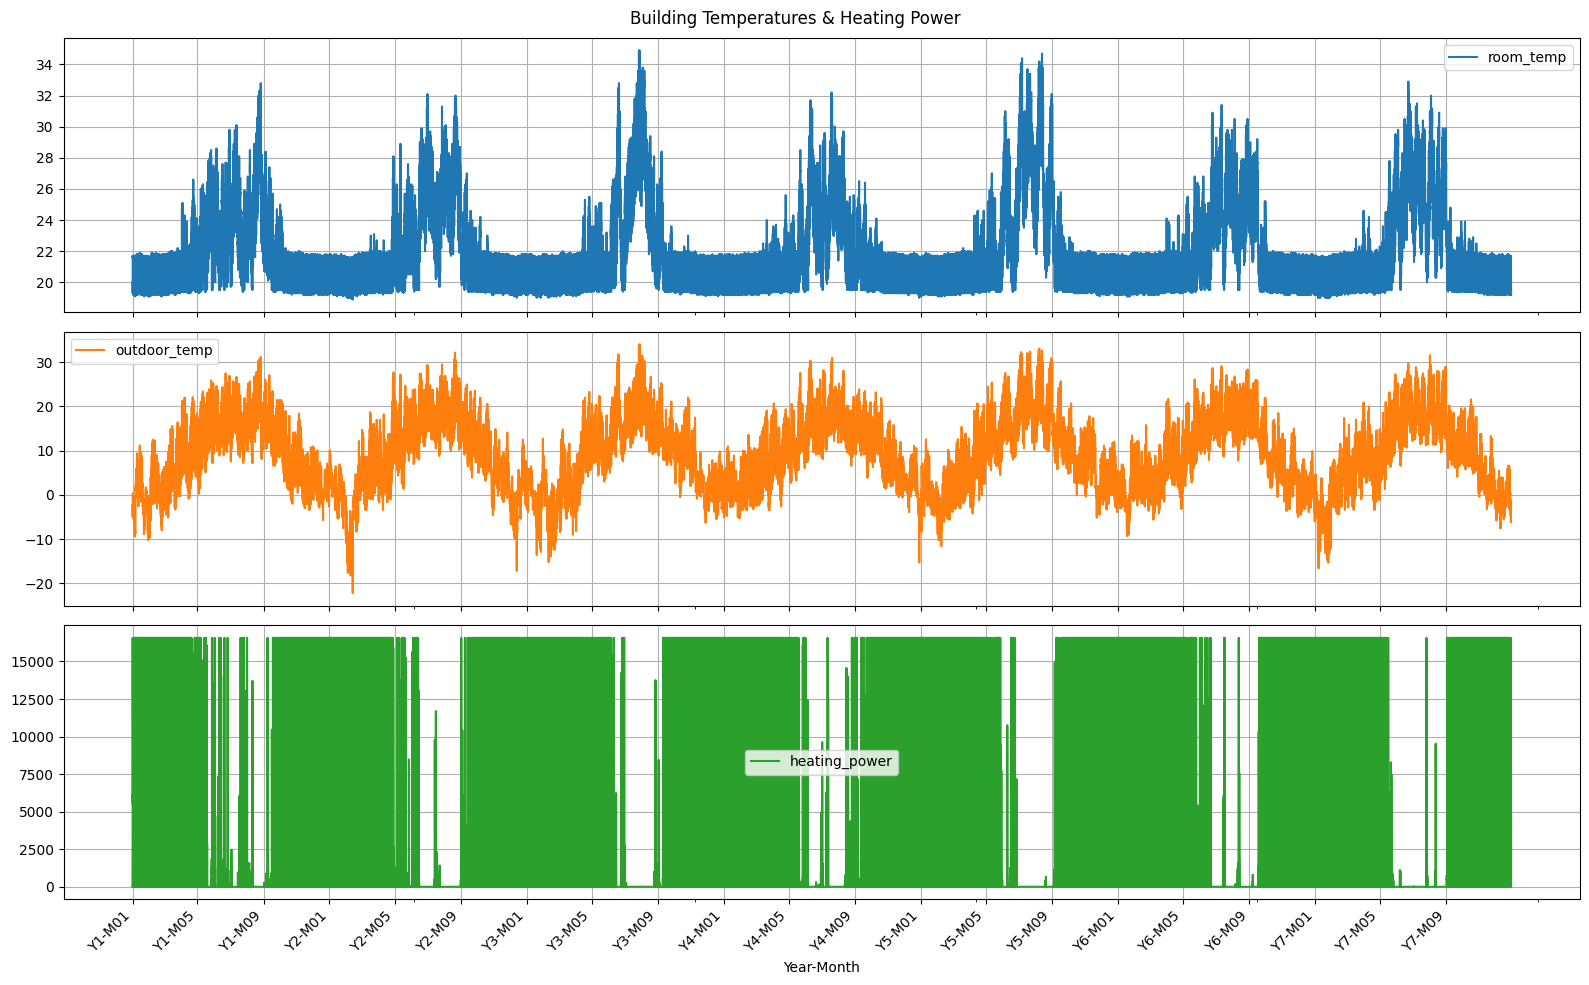

In [12]:
columns_to_plot = ['room_temp', 'outdoor_temp', 'heating_power']
df_plot = df_nodrift[columns_to_plot]
plot_slice = df_plot.head(4 * 24 * 365 * 7)  # 7 years @ 15-min

meta = df_nodrift.loc[plot_slice.index, ['year', 'month']].astype(int).reset_index(drop=True)

change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]  # ensure first tick at start
labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

target_ticks = 24
step = max(1, int(np.ceil(len(block_first_idx) / target_ticks)))
tick_pos = block_first_idx[::step]
tick_lbl = labels[::step]


axes = plot_slice.plot(
    subplots=True,
    layout=(3, 1),
    figsize=(16, 10),
    title="Building Temperatures & Heating Power",
    grid=True,
    legend=True
).ravel()

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_lbl, rotation=45, ha='right')

axes[-1].set_xlabel('Year-Month')
plt.tight_layout()
plt.show()

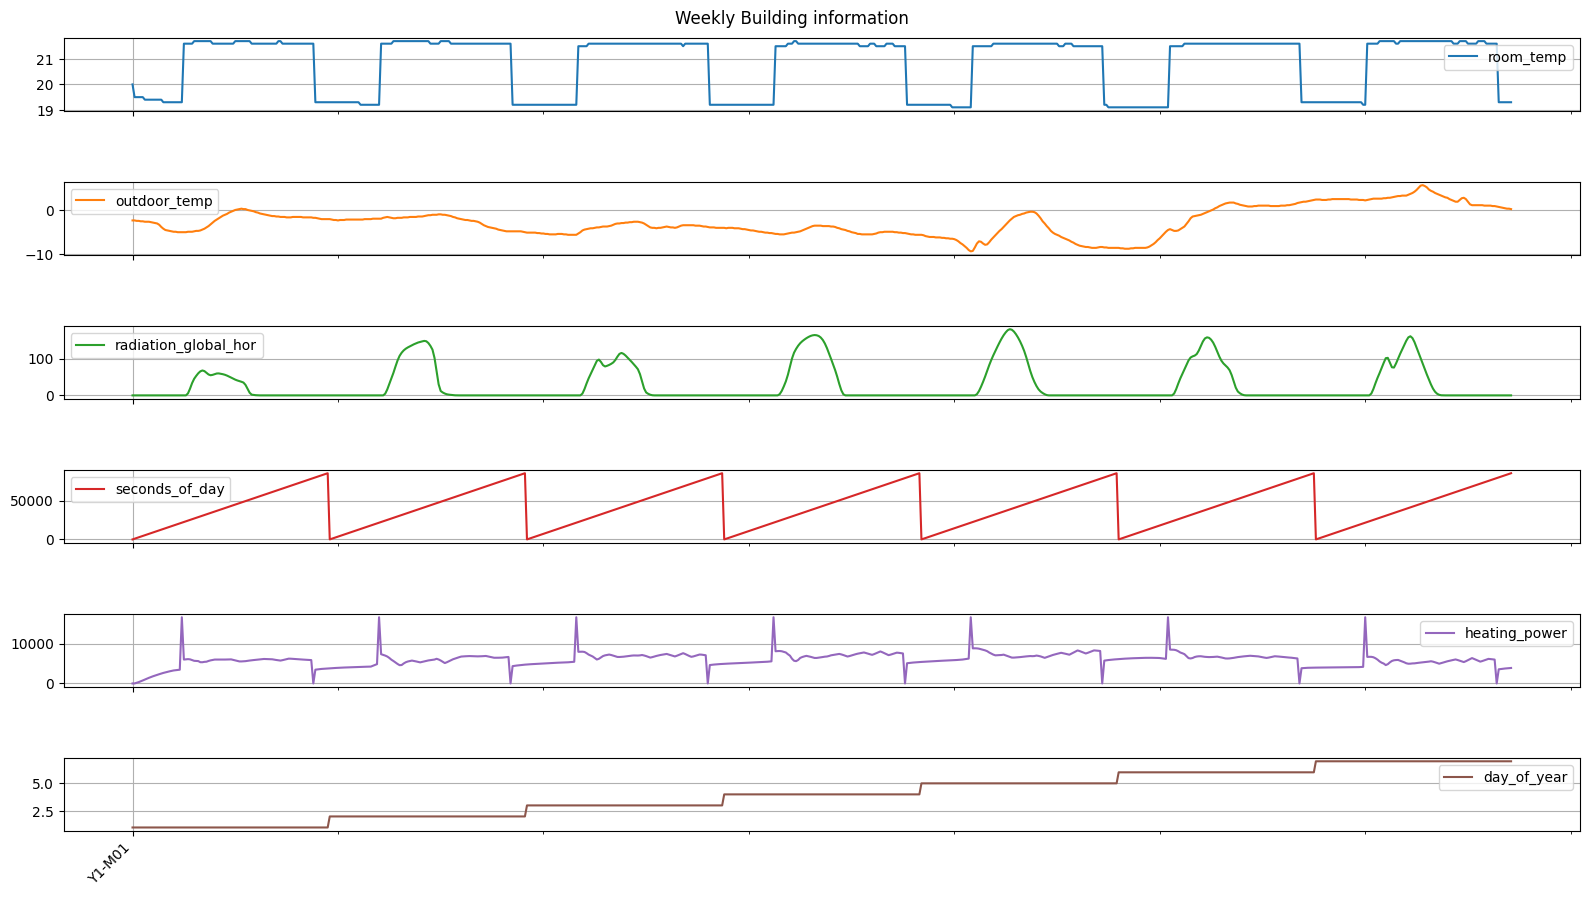

In [13]:
columns_to_plot = ['room_temp', 'outdoor_temp', 'radiation_global_hor','seconds_of_day','heating_power','day_of_year']
df_plot = df_nodrift[columns_to_plot]
plot_slice = df_plot.head(4 * 24 * 7)  # 7 years @ 15-min

meta = df_nodrift.loc[plot_slice.index, ['year', 'month']].astype(int).reset_index(drop=True)

change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]  # ensure first tick at start
labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

target_ticks = 24
step = max(1, int(np.ceil(len(block_first_idx) / target_ticks)))
tick_pos = block_first_idx[::step]
tick_lbl = labels[::step]


axes = plot_slice.plot(
    subplots=True,
    layout=(7, 1),
    figsize=(16, 10),
    title="Weekly Building information ",
    grid=True,
    legend=True
).ravel()

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_lbl, rotation=45, ha='right')

axes[-1].set_xlabel('Year-Month')
plt.tight_layout()
plt.show()

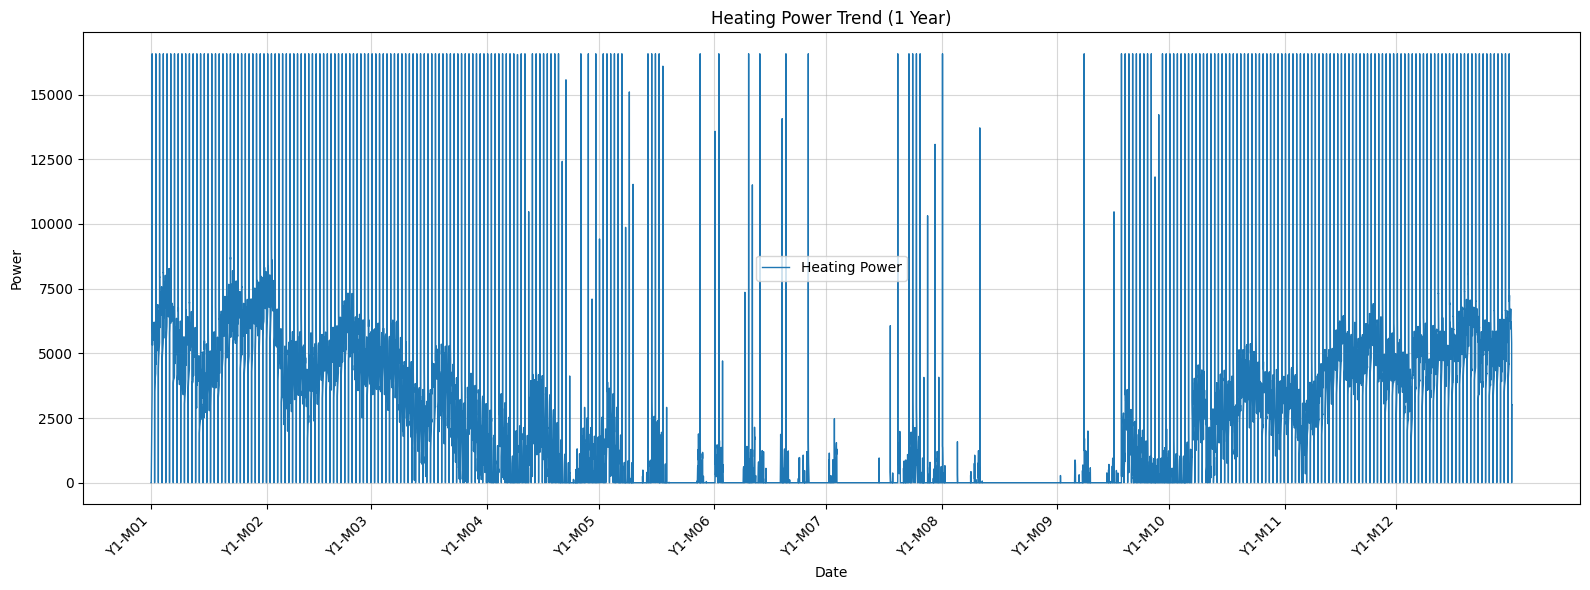

In [14]:
# 1. Define the slice for exactly one year (assuming 15-min data)
# 4 ticks/hour * 24 hours * 365 days = 35,040 rows
rows_for_one_year = 4 * 24 * 365 

# 2. Select Heating Power, plus Year/Month for the labels
columns_to_use = ['heating_power', 'year', 'month']
df_plot = df_nodrift[columns_to_use].head(rows_for_one_year).copy()

# 3. Generate Labels (Your existing logic, adapted)
# We look for where the month changes to place ticks
meta = df_plot[['year', 'month']].astype(int).reset_index(drop=True)
change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]

# Ensure the first tick is included
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]

labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

# 4. Plotting
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the heating power
ax.plot(df_plot.index, df_plot['heating_power'], label='Heating Power', linewidth=1)

# Apply the custom ticks
ax.set_xticks(block_first_idx)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Formatting
ax.set_title("Heating Power Trend (1 Year)")
ax.set_ylabel("Power")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

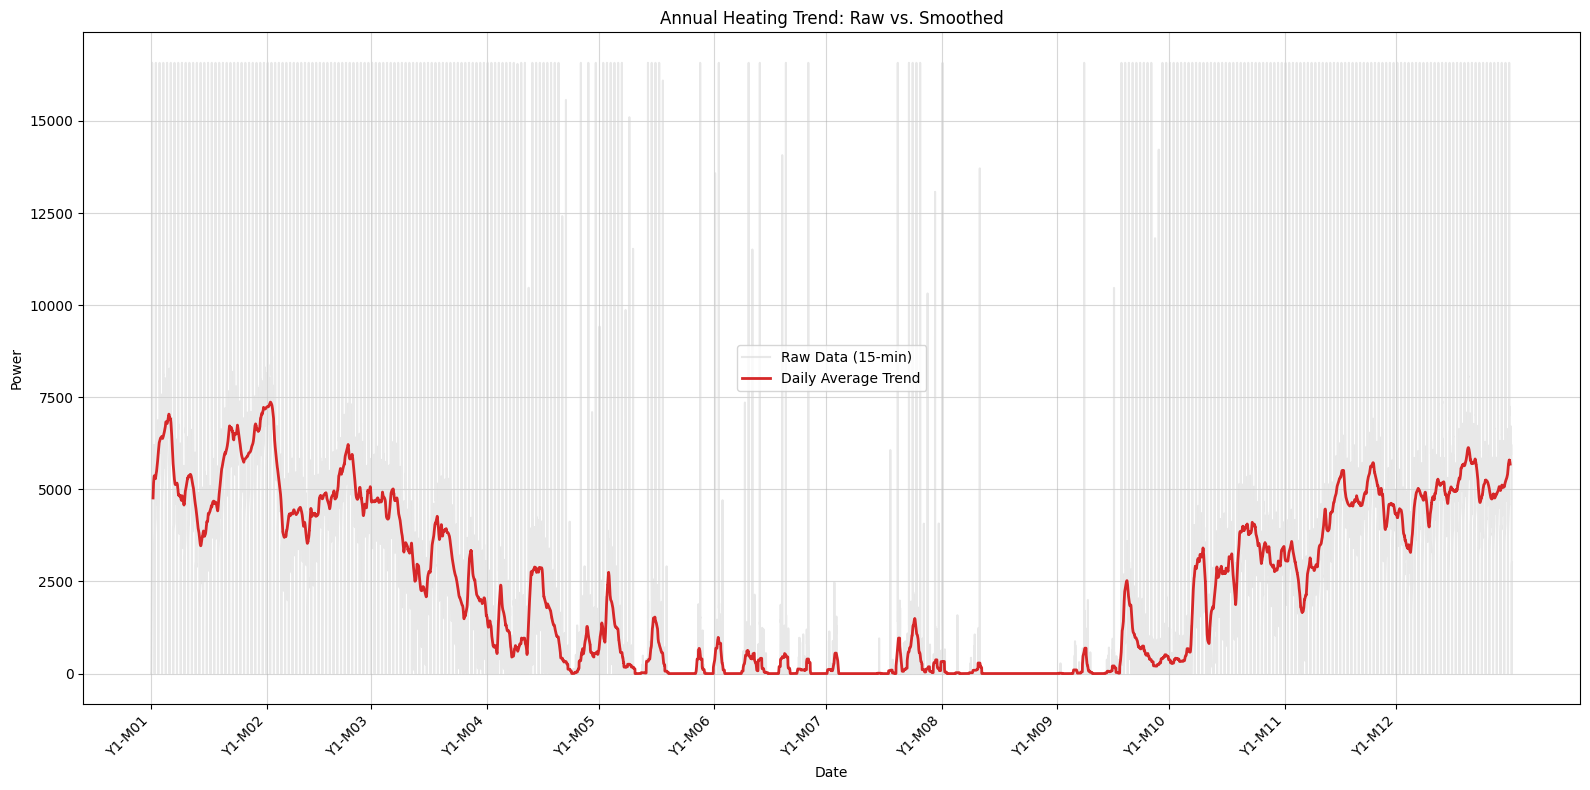

In [15]:
# 1. Setup the data (Assuming 15-min intervals)
rows_for_one_year = 4 * 24 * 365 
columns_to_use = ['heating_power', 'year', 'month']
df_plot = df_nodrift[columns_to_use].head(rows_for_one_year).copy()

# 2. Calculate a Moving Average
# Window = 96 (4 quarters * 24 hours = 1 day)
# This averages out the daily spikes to show the general daily trend
df_plot['heating_trend'] = df_plot['heating_power'].rolling(window=96, center=True).mean()

# 3. Generate Labels for plotting
meta = df_plot[['year', 'month']].astype(int).reset_index(drop=True)
change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]
labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

# 4. Plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Option A: Plot the raw data faintly in the background
ax.plot(df_plot.index, df_plot['heating_power'], color='lightgray', alpha=0.5, label='Raw Data (15-min)')

# Option B: Plot the smooth trend line on top
ax.plot(df_plot.index, df_plot['heating_trend'], color='#d62728', linewidth=2, label='Daily Average Trend')

# Formatting
ax.set_xticks(block_first_idx)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title("Annual Heating Trend: Raw vs. Smoothed")
ax.set_ylabel("Power")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

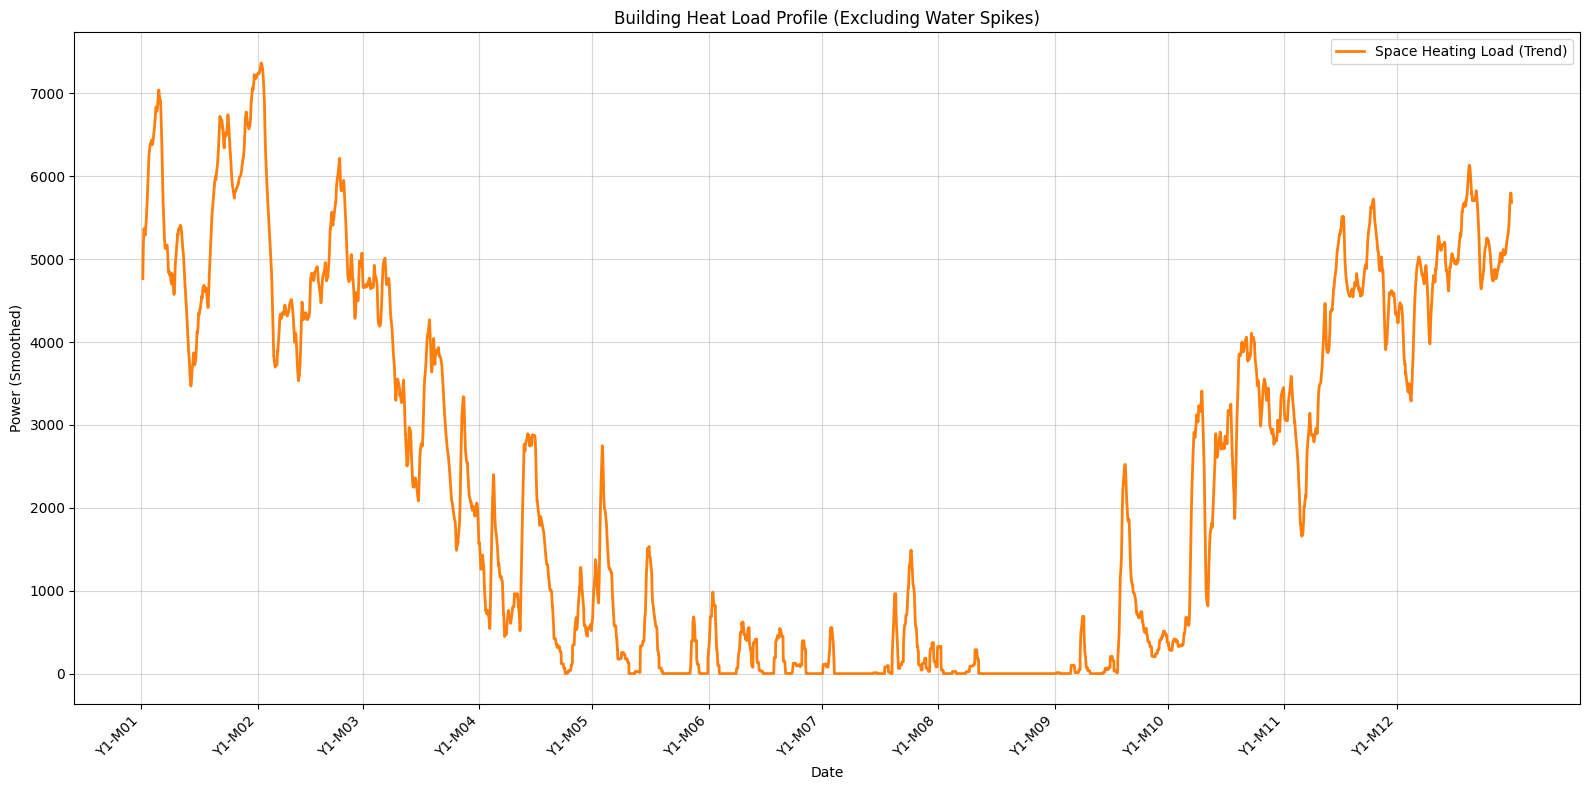

In [16]:
# 1. Setup the data (1 year)
rows_for_one_year = 4 * 24 * 365 
df_plot = df_nodrift[['heating_power', 'year', 'month']].head(rows_for_one_year).copy()

# 2. Extract the Heat Load (The Trend)
# We use a rolling window of 24 hours (4 * 24 = 96 steps)
# .mean() will smooth out the sharp spikes from the hot water.
df_plot['heat_load_trend'] = df_plot['heating_power'].rolling(window=96, center=True).mean()

# 3. Create Labels (same as before)
meta = df_plot[['year', 'month']].astype(int).reset_index(drop=True)
change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]
labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

# 4. Plot ONLY the Heat Load Trend
fig, ax = plt.subplots(figsize=(16, 8))

# We plot the calculated trend in a solid color (e.g., Orange or Red)
ax.plot(df_plot.index, df_plot['heat_load_trend'], color='#ff7f0e', linewidth=2, label='Space Heating Load (Trend)')

# Formatting
ax.set_xticks(block_first_idx)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title("Building Heat Load Profile (Excluding Water Spikes)")
ax.set_ylabel("Power (Smoothed)")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

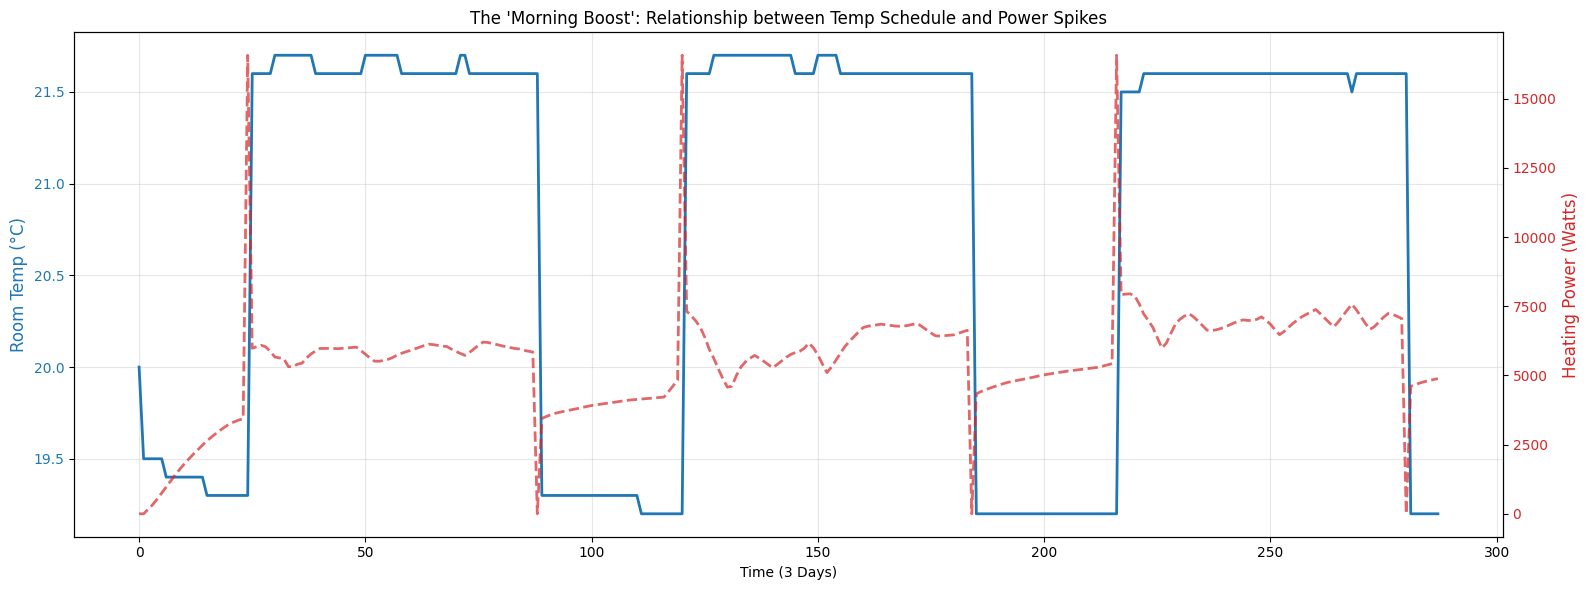

In [17]:
# 1. Select a small slice (3 Days) to see the daily startup clearly
# 3 days * 24 hours * 4 quarters = 288 data points
steps_3_days = 3 * 24 * 4
df_zoom = df_nodrift.head(steps_3_days).copy()

# 2. Setup the figure with dual axes
fig, ax1 = plt.subplots(figsize=(16, 6))

# 3. Plot Room Temperature on the Left Axis (Blue)
color_temp = 'tab:blue'
ax1.set_xlabel('Time (3 Days)')
ax1.set_ylabel('Room Temp (°C)', color=color_temp, fontsize=12)
ax1.plot(df_zoom.index, df_zoom['room_temp'], color=color_temp, linewidth=2, label='Room Temp')
ax1.tick_params(axis='y', labelcolor=color_temp)
ax1.grid(True, alpha=0.3)

# 4. Create a second y-axis for Power (Right Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# 5. Plot Heating Power on the Right Axis (Red)
color_pwr = 'tab:red'
ax2.set_ylabel('Heating Power (Watts)', color=color_pwr, fontsize=12)
ax2.plot(df_zoom.index, df_zoom['heating_power'], color=color_pwr, linewidth=2, linestyle='--', alpha=0.7, label='Heating Power')
ax2.tick_params(axis='y', labelcolor=color_pwr)

# 6. Add a title
plt.title("The 'Morning Boost': Relationship between Temp Schedule and Power Spikes")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

,year,energy_kWh
0,1,20173.616075
1,2,22391.400225
2,3,24411.277950
3,4,19206.051950
4,5,20785.630025
5,6,21524.053225
6,7,22296.517650
7,8,19497.234000
8,9,20578.666000


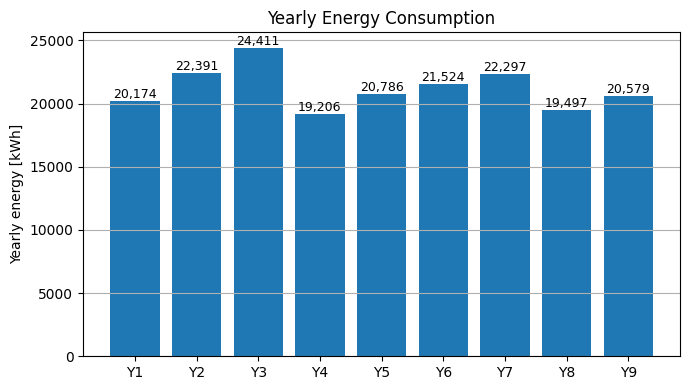

In [18]:
POWER_IN_WATTS = True 

# --- guards
req = {"heating_power", "timestamp_sec", "year"}
miss = [c for c in req if c not in df_nodrift.columns]
if miss:
    raise ValueError(f"df missing columns: {miss}")

# --- infer Δt (hours)
ts = np.sort(df_nodrift["timestamp_sec"].to_numpy())
if len(ts) < 2:
    raise ValueError("Need >=2 timestamps.")
dt_h = float(np.median(np.diff(ts)) / 3600.0)

# --- per-row energy → kWh
energy_row = df_nodrift["heating_power"] * dt_h
if POWER_IN_WATTS:
    energy_row = energy_row / 1000.0  # W·h → kWh

dfe = df_nodrift.copy()
dfe["energy_row_kWh"] = energy_row

# --- aggregate by year
yearly = (
    dfe.groupby("year", as_index=False)["energy_row_kWh"]
    .sum()
    .rename(columns={"energy_row_kWh": "energy_kWh"})
    .sort_values("year")
)
display(yearly)

# --- plot
plt.figure(figsize=(7,4))
x = np.arange(len(yearly))
vals = yearly["energy_kWh"].to_numpy()
plt.bar(x, vals)
plt.xticks(x, [f"Y{int(y)}" for y in yearly["year"]])
plt.ylabel("Yearly energy [kWh]")
plt.title("Yearly Energy Consumption")
plt.grid(True, axis="y")
for xi, v in zip(x, vals):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

,year,energy_kWh
0,1,20173.616075
1,2,22391.400225
2,3,12823.254975
3,4,1989.775675
4,5,2083.707025
5,6,2343.298900
6,7,2626.386725
7,8,2425.810450
8,9,2272.462075


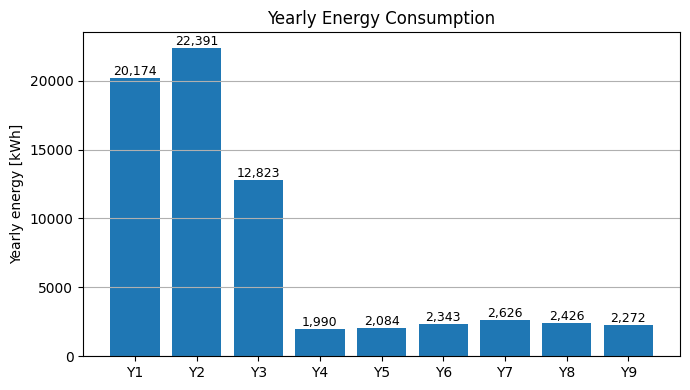

In [19]:
POWER_IN_WATTS = True 

# --- guards
req = {"heating_power", "timestamp_sec", "year"}
miss = [c for c in req if c not in df_drift.columns]
if miss:
    raise ValueError(f"df missing columns: {miss}")

# --- infer Δt (hours)
ts = np.sort(df_drift["timestamp_sec"].to_numpy())
if len(ts) < 2:
    raise ValueError("Need >=2 timestamps.")
dt_h = float(np.median(np.diff(ts)) / 3600.0)

# --- per-row energy → kWh
energy_row = df_drift["heating_power"] * dt_h
if POWER_IN_WATTS:
    energy_row = energy_row / 1000.0  # W·h → kWh

dfe = df_drift.copy()
dfe["energy_row_kWh"] = energy_row

# --- aggregate by year
yearly = (
    dfe.groupby("year", as_index=False)["energy_row_kWh"]
    .sum()
    .rename(columns={"energy_row_kWh": "energy_kWh"})
    .sort_values("year")
)
display(yearly)

# --- plot
plt.figure(figsize=(7,4))
x = np.arange(len(yearly))
vals = yearly["energy_kWh"].to_numpy()
plt.bar(x, vals)
plt.xticks(x, [f"Y{int(y)}" for y in yearly["year"]])
plt.ylabel("Yearly energy [kWh]")
plt.title("Yearly Energy Consumption")
plt.grid(True, axis="y")
for xi, v in zip(x, vals):
    plt.text(xi, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

In [20]:
LOOKBACK = 106        
HORIZON  = 4 
STRIDE   = 1


FEATS = [
    "room_temp","outdoor_temp","radiation_global_hor",
    'tod_sin','tod_cos',
    'doy_sin','doy_cos',
    "heating_power"
]
idx_t = FEATS.index("heating_power")  

In [21]:
def make_windows_multi(F: np.ndarray, y: np.ndarray, lookback: int, horizon: int, stride: int = 1):
    Xs, Ys = [], []
    N, _ = F.shape
    for t in range(lookback, N - horizon + 1, stride):
        Xs.append(F[t - lookback:t, :])      # past L rows
        Ys.append(y[t : t + horizon])        # next H targets (scaled)
    return np.stack(Xs), np.stack(Ys)

In [22]:
# ===================== 1) FIT SCALER + TRAIN ON NO-DRIFT Y1–Y3 =====================
# Build Y1–Y3 nodrift block and chrono split 70/30
nodrift_y123 = df_nodrift[df_nodrift['year'].isin([1,2,3])].reset_index(drop=True)
split_idx = int(0.7 * len(nodrift_y123))

train_df = nodrift_y123.iloc[:split_idx].reset_index(drop=True)
val_df   = nodrift_y123.iloc[split_idx:].reset_index(drop=True)

# Fit single MinMax on TRAIN features (including target column)
X_tr = train_df[FEATS].to_numpy(float)
X_va = val_df[FEATS].to_numpy(float)

X_scaler = MinMaxScaler()
X_scaler.fit(X_tr)

# Transform and build windows
X_tr_s = X_scaler.transform(X_tr); y_tr_s = X_tr_s[:, idx_t].copy()
X_va_s = X_scaler.transform(X_va); y_va_s = X_va_s[:, idx_t].copy()
Xtr_win, Ytr_win = make_windows_multi(X_tr_s, y_tr_s, LOOKBACK, HORIZON, STRIDE)
Xva_win, Yva_win = make_windows_multi(X_va_s, y_va_s, LOOKBACK, HORIZON, STRIDE)


In [23]:
# def build_model_per_layer(input_steps: int,
#                           n_feats: int,
#                           horizon: int,
#                           n_layers: int,
#                           units_list: list[int],
#                           dropout_list: list[float],
#                           activations_list: list[str],
#                           optimizer_name: str,
#                           lr: float) -> tf.keras.Model:
#     model = tf.keras.Sequential([tf.keras.layers.Input(shape=(input_steps, n_feats))])
#     for li in range(n_layers):
#         return_seq = (li < n_layers - 1)
#         model.add(tf.keras.layers.LSTM(
#             units_list[li],
#             return_sequences=return_seq,
#             activation=activations_list[li]
#         ))
#         if dropout_list[li] > 0:
#             model.add(tf.keras.layers.Dropout(dropout_list[li]))
#     model.add(tf.keras.layers.Dense(horizon))  # linear head

#     if optimizer_name == "adam":
#         opt = tf.keras.optimizers.Adam(learning_rate=lr)
#     elif optimizer_name == "nadam":
#         opt = tf.keras.optimizers.Nadam(learning_rate=lr)
#     else:
#         opt = tf.keras.optimizers.RMSprop(learning_rate=lr)

#     model.compile(optimizer=opt, loss="mse", metrics=["mae"])
#     return model

# def objective(trial: optuna.trial.Trial) -> float:
#     # Shared / global hparams
#     lookback   = trial.suggest_int("lookback", 40, 108)
#     n_layers   = trial.suggest_int("n_layers", 1, 3)
#     batch_sz   = trial.suggest_int("batch_size", 32, 512, log=True)
#     lr         = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
#     optimizer  = trial.suggest_categorical("optimizer", ["adam", "nadam", "rmsprop"])

#     # Per-layer params
#     units_list, dropout_list, acts_list = [], [], []
#     for li in range(n_layers):
#         u  = trial.suggest_int(f"units_l{li+1}", 32, 512, log=True)
#         d  = trial.suggest_float(f"dropout_l{li+1}", 0.0, 0.5)
#         ac = trial.suggest_categorical(f"act_l{li+1}", ["tanh", "relu"])
#         units_list.append(u)
#         dropout_list.append(d)
#         acts_list.append(ac)

#     # Windows for this lookback (arrays already prepared outside: X_tr_s, y_tr_s, X_va_s, y_va_s)
#     Xtr_win, Ytr_win = make_windows_multi(X_tr_s, y_tr_s, lookback, HORIZON, STRIDE)
#     Xva_win, Yva_win = make_windows_multi(X_va_s, y_va_s, lookback, HORIZON, STRIDE)
#     if len(Xtr_win) < 100 or len(Xva_win) < 100:
#         raise optuna.TrialPruned()

#     # Build & train
#     model = build_model_per_layer(
#         input_steps=lookback, n_feats=Xtr_win.shape[-1], horizon=HORIZON,
#         n_layers=n_layers, units_list=units_list, dropout_list=dropout_list,
#         activations_list=acts_list, optimizer_name=optimizer, lr=lr
#     )
#     es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
#     pruning_cb = TFKerasPruningCallback(trial, monitor="val_loss")

#     hist = model.fit(
#         Xtr_win, Ytr_win,
#         validation_data=(Xva_win, Yva_win),
#         epochs=1000,
#         batch_size=batch_sz,
#         verbose=0,
#         shuffle=True,
#         callbacks=[es, pruning_cb]
#     )
#     val_loss = float(np.min(hist.history["val_loss"]))
#     trial.report(val_loss, step=0)
#     return val_loss

# # ---- Run study ----
# N_TRIALS = 100
# study = optuna.create_study(direction="minimize", study_name="lstm_optuna_per_layer_act_no_cast")
# study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

# print("\nBest trial:")
# print(f"  min val_loss (MSE scaled): {study.best_value:.6f}")
# for k, v in study.best_trial.params.items():
#     print(f"  {k}: {v}")

# # ---- Rebuild best model (no casts) ----
# best = study.best_trial.params
# BEST_LOOKBACK = int(best["lookback"])
# BEST_LAYERS   = int(best["n_layers"])
# BEST_BATCH    = int(best["batch_size"])
# BEST_LR       = float(best["lr"])
# BEST_OPT      = best["optimizer"]

# best_units   = [int(best[f"units_l{i+1}"]) for i in range(BEST_LAYERS)]
# best_dropout = [float(best[f"dropout_l{i+1}"]) for i in range(BEST_LAYERS)]
# best_acts    = [best[f"act_l{i+1}"] for i in range(BEST_LAYERS)]

# Xtr_win_b, Ytr_win_b = make_windows_multi(X_tr_s, y_tr_s, BEST_LOOKBACK, HORIZON, STRIDE)
# Xva_win_b, Yva_win_b = make_windows_multi(X_va_s, y_va_s, BEST_LOOKBACK, HORIZON, STRIDE)

# optuna_best_model = build_model_per_layer(
#     input_steps=BEST_LOOKBACK,
#     n_feats=Xtr_win_b.shape[-1],
#     horizon=HORIZON,
#     n_layers=BEST_LAYERS,
#     units_list=best_units,
#     dropout_list=best_dropout,
#     activations_list=best_acts,
#     optimizer_name=BEST_OPT,
#     lr=BEST_LR
# )
# print("\nRefit config:", {
#     "lookback": BEST_LOOKBACK, "n_layers": BEST_LAYERS,
#     "units": best_units, "dropout": best_dropout, "acts": best_acts,
#     "batch_size": BEST_BATCH, "lr": BEST_LR, "optimizer": BEST_OPT
# })

# es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# optuna_best_model.fit(
#     Xtr_win_b, Ytr_win_b,
#     validation_data=(Xva_win_b, Yva_win_b),
#     epochs=1000,
#     batch_size=BEST_BATCH,
#     verbose=0,
#     shuffle=True,
#     callbacks=[es]
# )


In [24]:
def inv_steps_from_X_scaler(Ys_scaled_2d: np.ndarray, X_scaler: MinMaxScaler, idx_t: int, horizon: int):
    flat = Ys_scaled_2d.reshape(-1)
    flat_inv = (flat - X_scaler.min_[idx_t]) / X_scaler.scale_[idx_t]  # MinMax inverse
    return flat_inv.reshape(-1, horizon)

def build_model(input_steps: int, n_feats: int, horizon: int) -> tf.keras.Model:
    # Simple, strong baseline LSTM (you can swap in your tuned sizes if you prefer)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_steps, n_feats)),
        tf.keras.layers.LSTM(85, return_sequences=True),
        tf.keras.layers.Dropout(0.08836895774435721),
        tf.keras.layers.LSTM(188, return_sequences=False),
        tf.keras.layers.Dropout(0.1596828160072332),
        tf.keras.layers.Dense(horizon)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.0007509794596043137)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

def metrics_per_horizon(Y_true: np.ndarray, Y_pred: np.ndarray):
    H = Y_true.shape[1]
    maes  = [mean_absolute_error(Y_true[:,h], Y_pred[:,h]) for h in range(H)]
    rmses = [mean_squared_error(Y_true[:,h], Y_pred[:,h], squared=False) for h in range(H)]
    return maes, rmses, float(np.mean(maes)), float(np.mean(rmses))

def eval_year(df_src: pd.DataFrame, X_scaler: MinMaxScaler, model: tf.keras.Model, year: int):
    # Slice a single year, scale with TRAIN scaler, window, predict, inverse
    d = df_src[df_src['year'] == year].reset_index(drop=True)
    if len(d) < LOOKBACK + HORIZON + 1:
        return None  # not enough data
    X = d[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, HORIZON, STRIDE)
    Xw = Xw.astype('float32'); Yw = Yw.astype('float32')
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,     X_scaler, idx_t, HORIZON)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, HORIZON)
    maes, rmses, mae_avg, rmse_avg = metrics_per_horizon(Y_true, Y_hat)
    return {
        "H1_MAE": maes[0], "H2_MAE": maes[1], "H3_MAE": maes[2], "H4_MAE": maes[3], "MAE_avg": mae_avg,
        "H1_RMSE": rmses[0], "H2_RMSE": rmses[1], "H3_RMSE": rmses[2], "H4_RMSE": rmses[3], "RMSE_avg": rmse_avg,
        "n_windows": len(Y_true)
    }

In [25]:
# Build & train model
model = build_model(LOOKBACK, len(FEATS), HORIZON)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(
    Xtr_win, Ytr_win,
    validation_data=(Xva_win, Yva_win),
    epochs=1000,
    batch_size=41,
    verbose=1,
    callbacks=[es],
    shuffle=True
)

baseline_model = tf.keras.models.clone_model(model)
baseline_model.build(model.input_shape)
baseline_model.set_weights(model.get_weights())
baseline_model.compile(optimizer=tf.keras.optimizers.deserialize(tf.keras.optimizers.serialize(model.optimizer)),
                       loss=model.loss, metrics=[m for m in model.metrics if m.name != "loss"])

Epoch 1/1000


2025-12-09 14:33:07.959641: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


  33/1794 ━━━━━━━━━━━━━━━━━━━━ 4:51 166ms/step - loss: 0.0212 - mae: 0.1016

KeyboardInterrupt: 